In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from kneed import KneeLocator

import warnings
warnings.filterwarnings("ignore")

In [2]:
customer_data_df = pd.read_csv("../Data/pre_processed_data_1.csv", sep = "\t")
customer_data_df

,Income,Response,Kids,Expenses,TotalAcceptedCmp,NumTotalPurchases,Age,Days_Customer,Related,Single,Unrelated,Post-Graduate,Under-Graduate
0,58138.0,1,0,1617,0,25,65,3668,0.0,1.0,0.0,1.0,0.0
1,46344.0,0,2,27,0,6,68,2822,0.0,1.0,0.0,1.0,0.0
2,71613.0,0,0,776,0,21,57,3169,1.0,0.0,0.0,1.0,0.0
3,26646.0,0,1,53,0,8,38,2762,1.0,0.0,0.0,1.0,0.0
4,58293.0,0,1,422,0,19,41,3018,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,61223.0,0,1,1341,0,18,55,3238,1.0,0.0,0.0,1.0,0.0
2236,64014.0,0,3,444,1,22,76,2758,1.0,0.0,0.0,1.0,0.0
2237,56981.0,0,0,1241,1,19,41,3012,0.0,1.0,0.0,1.0,0.0
2238,69245.0,0,1,843,0,23,66,3013,1.0,0.0,0.0,1.0,0.0


In [3]:
# drop outliers
q3 = customer_data_df.quantile(0.75)
q1 = customer_data_df.quantile(0.25)
iqr = q3 - q1
lower_range = q1 - (1.5 * iqr)
upper_range = q3 + (1.5 * iqr)

customer_data_df = customer_data_df[~( (customer_data_df < lower_range)|(customer_data_df > upper_range) ).any(axis=1)]

In [4]:
ss = StandardScaler()
x = ss.fit_transform(customer_data_df)

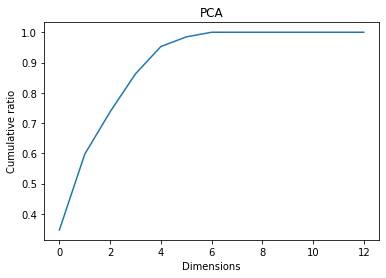

In [5]:
pca = PCA()
pca.fit(x)
cum_ratio = pca.explained_variance_ratio_.cumsum()
plt.plot(range(len(cum_ratio)), cum_ratio)
plt.title('PCA')
plt.xlabel('Dimensions')
plt.ylabel('Cumulative ratio')
plt.show()

In [6]:
pca = PCA(n_components = 6)
x_pca = pca.fit_transform(x)

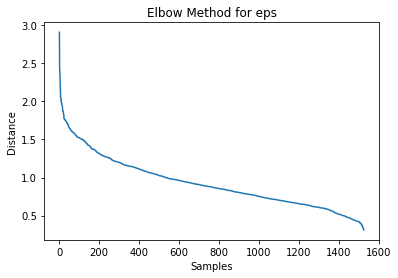

In [7]:
# Elbow method to find optimum eps distance
neighbors = x_pca.shape[1]*2
nbrs = NearestNeighbors(n_neighbors=neighbors).fit(x)
distances, indices = nbrs.kneighbors(x)
distance_desc = sorted(distances[:, 6], reverse=True)
plt.plot(range(1,len(distance_desc)+1),distance_desc)
plt.title('Elbow Method for eps')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.show()

Estimate eps with elbow method: 1.7487699669934176


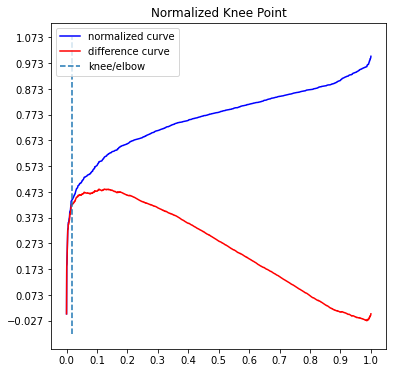

In [8]:
# find elbow point
kneedle = KneeLocator(range(1,len(distance_desc)+1),distance_desc,S=1.0,curve="convex", direction="decreasing")
kneedle.plot_knee_normalized()
print("Estimate eps with elbow method:", kneedle.knee_y)

In [9]:
clusters = []
scores = []
eps_list = [1, 1.5, 2, 2.5]
min_samples_list = [9, 12, 16, 20]
for eps in eps_list:
    for min_samples in min_samples_list:
        dbscan = DBSCAN(eps=eps, min_samples = min_samples)
        pred = dbscan.fit_predict(x_pca)
        score = silhouette_score(x_pca, pred)
        clusters.append(len(set(pred)))
        scores.append(score)

print("The best score:",max(scores))
print("The number of clusters:", clusters[np.argmax(scores)])
print("eps:", eps_list[(np.argmax(scores)+1)//len(min_samples_list)])
print("min_samples:", min_samples_list[np.argmax(scores)%len(min_samples_list)])

The best score: 0.2855081636584036
The number of clusters: 2
eps: 2
min_samples: 9


When eps = 2 and min_samples = 9, the silhouette score reaches the best. The data is devided into two clusters.

In [10]:
dbscan = DBSCAN(eps=2, min_samples = 9)
pred = dbscan.fit_predict(x_pca)

In [11]:
customer_data_df['Cluster'] = pred
customer_data_df

,Income,Response,Kids,Expenses,TotalAcceptedCmp,NumTotalPurchases,Age,Days_Customer,Related,Single,Unrelated,Post-Graduate,Under-Graduate,Cluster
1,46344.0,0,2,27,0,6,68,2822,0.0,1.0,0.0,1.0,0.0,0
2,71613.0,0,0,776,0,21,57,3169,1.0,0.0,0.0,1.0,0.0,1
3,26646.0,0,1,53,0,8,38,2762,1.0,0.0,0.0,1.0,0.0,1
4,58293.0,0,1,422,0,19,41,3018,1.0,0.0,0.0,1.0,0.0,1
5,62513.0,0,1,716,0,22,55,3150,1.0,0.0,0.0,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2231,44802.0,0,0,1049,0,27,52,3534,0.0,1.0,0.0,1.0,0.0,0
2232,26816.0,0,0,22,0,4,36,3538,0.0,1.0,0.0,1.0,0.0,0
2234,34421.0,0,1,30,0,4,48,3395,1.0,0.0,0.0,1.0,0.0,1
2235,61223.0,0,1,1341,0,18,55,3238,1.0,0.0,0.0,1.0,0.0,1


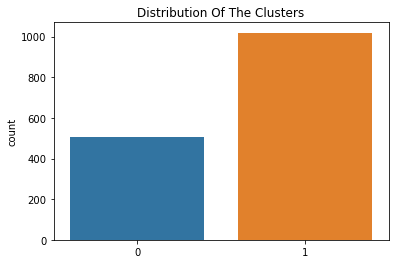

In [12]:
# The number of samples in each cluster
plot = sns.countplot(x = pred)
plot.set_title("Distribution Of The Clusters")
plt.show()

In [13]:
# categorical_feature = ['Response','Kids', 'TotalAcceptedCmp', 'Related', 'Single',
#        'Unrelated', 'Post-Graduate', 'Under-Graduate']
# for feature,subplot in zip(categorical_feature,ax.flatten()):
#     sns.catplot(data = customer_data_df, x = feature, hue = 'Cluster', kind="count")
# plt.show()

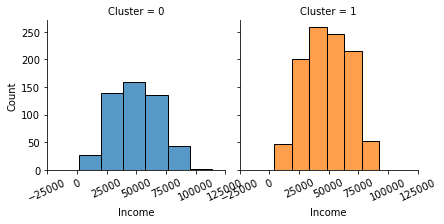

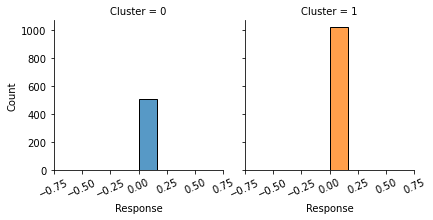

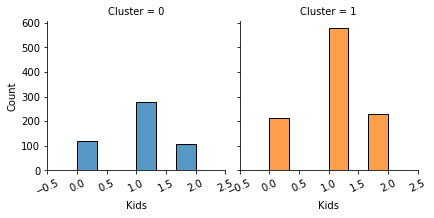

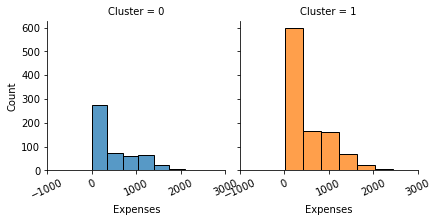

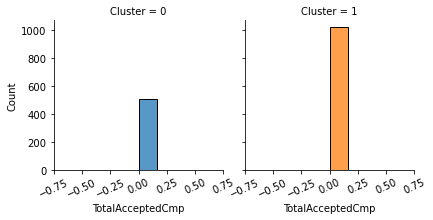

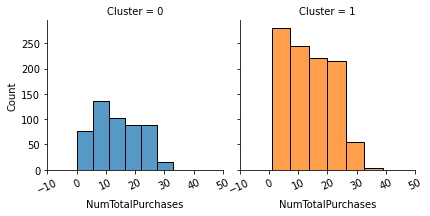

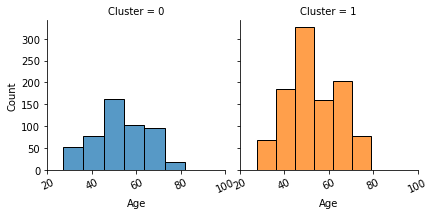

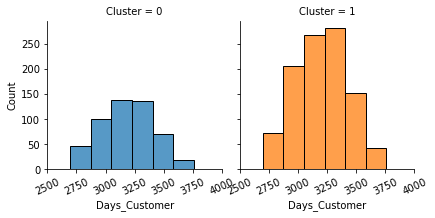

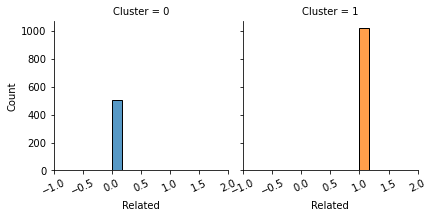

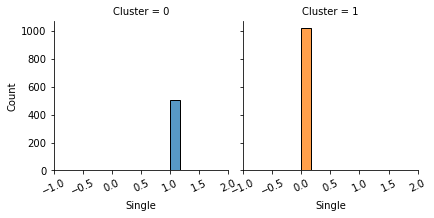

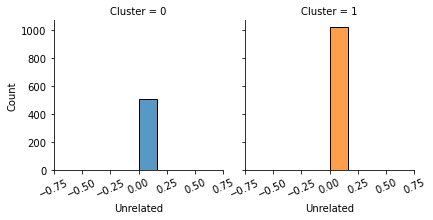

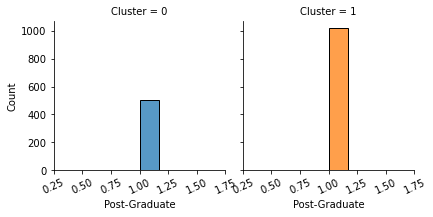

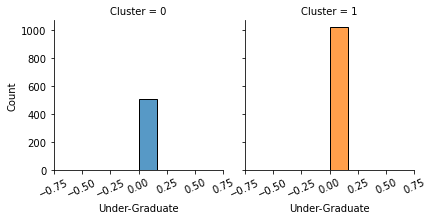

In [14]:
# The distribution of each feature in each cluster
for feature in customer_data_df.columns[:-1]:
    diagrams = sns.FacetGrid(customer_data_df, col = "Cluster", hue = "Cluster")
    diagrams.map(sns.histplot, feature, bins = 6, ec="k") 
    diagrams.set_xticklabels(rotation=25)
plt.show()

The clustering is mainly based on marital status.